In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
np.set_printoptions(precision=3, suppress=True)

In [2]:
def count_bits(x):
    return bin(x).count('1')
count_bits_v = np.vectorize(count_bits)

def nkron(f,n):
    
    fn = np.kron(f,f)
    for i in range(n-2):
        fn = np.kron(fn,f)
    return fn

def pw_model(n, n_ops):
    
    # generate a bunch of pairwise operators
    
    model, pars = [], []
    jij = np.zeros((n,n))
    
    while len(model) < n_ops:
        
        u = np.random.randint(1,n)
        v = np.random.randint(0,u)
        
        op = 2**u + 2**v
        
        if op not in model:
            
            model.append(op)
            g = np.random.normal(0,1)
            pars.append(g)
            jij[u,v] = g
            jij[v,u] = g
            
            print(op, format(op,f'0{n}b'))
            
    return model, pars, jij

def state_probs(n, fn, g, M):
    
    fm = fn[:,M]
    g_ops = np.dot(fm,g)
    z = np.sum(np.exp(g_ops))
    dz = np.sum(fm * np.exp(g_ops).reshape(-1,1), axis=0)
    p = np.exp(g_ops)/z
    
    return z, dz, dz/z, p

def Sn(g, data, u):
    
    gamma = 0
    
    g[u] = 0
    m = [2**u + 2**i for i in range(n)]
    op = 1 - 2 * np.mod(count_bits_v(np.bitwise_and(data.reshape(-1,1),m)),2)   
    g_ops = np.sum(-op * g, axis=1)
    
    sn = np.mean(np.exp(g_ops))
    dsn = np.mean(-op * np.exp(g_ops).reshape(-1,1), axis=0)
    dsn[u] = 0
    
    return sn + gamma * np.sum(np.abs(g)), dsn + gamma * np.sign(g)

In [33]:
n = 14
N = 2500
f1 = np.array([[1,1],[1,-1]])
fn = nkron(f1,n)


In [34]:
# n = 121
# model, pars, jij = pw_model(n,1000)
# np.savetxt("./example_data/test_121_1000.dat",pars, delimiter="\n")

In [36]:
model, pars, jij = pw_model(n,7)
rng = np.random.default_rng(seed = 1)
z, dz, phi, p = state_probs(n, fn, pars, model)
data = rng.choice(np.arange(2**n), N, p = p)

24 00000000011000
66 00000001000010
2064 00100000010000
10240 10100000000000
160 00000010100000
288 00000100100000
80 00000001010000


In [ ]:
# ./rise -i test_data_n10_N20 -p ./example_data -n 10
# ./rise -i pytestdata_14_2500 -p ./example_data -n 14

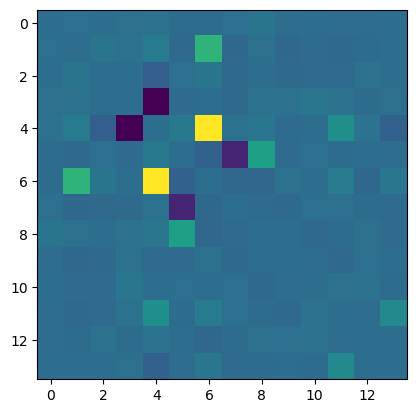

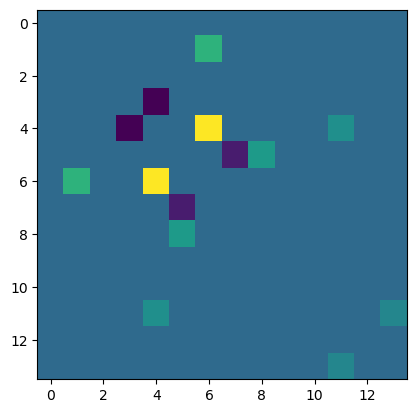

In [62]:
model = np.loadtxt("./example_data/pytestdata_14_2500_fitted_jij.pars", usecols=1)
bindices = np.loadtxt("./example_data/pytestdata_14_2500_fitted_jij.pars", usecols=0, dtype="str")
bindices
ones_indices = [tuple(13-np.where(np.array(list(bitstring)) == '1')[0]) for bitstring in bindices]

jij_mod = np.zeros((n,n))
for i, tup in enumerate(ones_indices):
    jij_mod[tup[0],tup[1]] = model[i]
    jij_mod[tup[1],tup[0]] = model[i]


plt.imshow(jij_mod)
plt.figure()
plt.imshow(jij)

In [37]:
import numpy as np

i = data[0]
bitstring = list(map(lambda i: format(i, '0{}b'.format(n)), data))
bitstring_array = np.array(bitstring)
np.savetxt(f"./example_data/pytestdata_{n}_{N}.dat", bitstring_array, fmt="%s")

[ 0.    -2.23  -0.004 -0.08   0.309 -0.039  0.352 -0.147 -0.076 -0.029]


[-2.229  0.     0.004 -0.07   0.377 -0.073  0.359 -0.134 -0.021 -0.058]
[ 0.008  0.019  0.     0.012  0.732 -0.018  0.063 -0.017  0.112 -0.182]
[-0.046 -0.038  0.012  0.    -0.155  0.014 -0.166  0.008  0.007  0.007]
[ 0.106  0.294  0.773 -0.108  0.     0.068 -1.941 -0.04   0.11   0.008]
[-0.036 -0.061 -0.016  0.014  0.043  0.     0.023 -0.001  0.004  0.003]
[ 0.28   0.314  0.08  -0.163 -1.912  0.019  0.    -0.013  0.059  0.051]
[-0.119 -0.111 -0.013  0.008 -0.005 -0.001  0.003  0.     0.004 -0.012]
[-0.072 -0.033  0.113  0.007  0.022  0.004  0.044  0.004  0.    -0.005]
[-0.041 -0.062 -0.182  0.007  0.065  0.003  0.048 -0.012 -0.005  0.   ]
[[ 0.    -2.229  0.002 -0.063  0.207 -0.037  0.316 -0.133 -0.074 -0.035]
 [-2.229  0.     0.012 -0.054  0.335 -0.067  0.336 -0.122 -0.027 -0.06 ]
 [ 0.002  0.012  0.     0.012  0.753 -0.017  0.071 -0.015  0.113 -0.182]
 [-0.063 -0.054  0.012  0.    -0.131  0.014 -0.164  0.008  0.007  0.007]
 [ 0.207  0.335  0.753 -0.131  0.     0.056 -1.927 -0.023  0

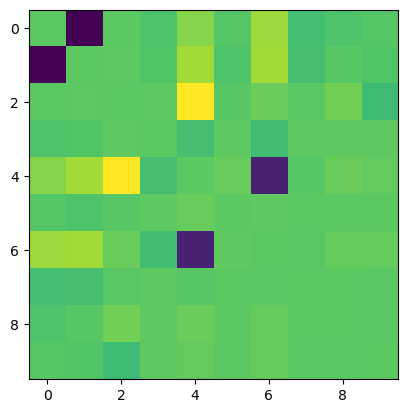

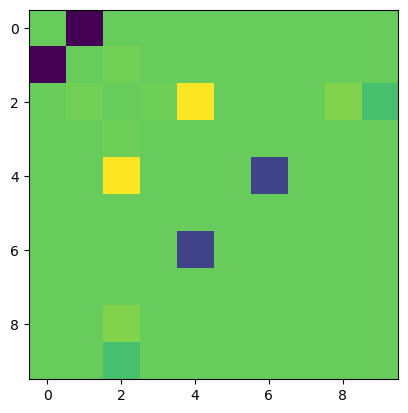

In [7]:
jij_fit = np.zeros((n,n))
for i in range(n):
    g0 = np.zeros(n)
    min_sn = minimize(Sn, x0 = g0, args = (data,i), jac = True)  
    jij_fit[i,:] = min_sn.x
    print(min_sn.x)

jij_fit = (jij_fit + jij_fit.T)/2


print(jij_fit)
print(jij)
plt.imshow(jij_fit)
plt.figure()
plt.imshow(jij)

In [8]:
for op, p in zip(model, pars):
    print(op, p)

260 0.12369365638776636
6 0.053204611021206244
3 -2.279095888933216
12 0.02432972098285885
80 -1.6870232603486945
516 -0.18127136796552087
20 0.6830619801201135


In [9]:
jij_fit

array([[ 0.   , -2.229,  0.002, -0.063,  0.207, -0.037,  0.316, -0.133,
        -0.074, -0.035],
       [-2.229,  0.   ,  0.012, -0.054,  0.335, -0.067,  0.336, -0.122,
        -0.027, -0.06 ],
       [ 0.002,  0.012,  0.   ,  0.012,  0.753, -0.017,  0.071, -0.015,
         0.113, -0.182],
       [-0.063, -0.054,  0.012,  0.   , -0.131,  0.014, -0.164,  0.008,
         0.007,  0.007],
       [ 0.207,  0.335,  0.753, -0.131,  0.   ,  0.056, -1.927, -0.023,
         0.066,  0.036],
       [-0.037, -0.067, -0.017,  0.014,  0.056,  0.   ,  0.021, -0.001,
         0.004,  0.003],
       [ 0.316,  0.336,  0.071, -0.164, -1.927,  0.021,  0.   , -0.005,
         0.051,  0.05 ],
       [-0.133, -0.122, -0.015,  0.008, -0.023, -0.001, -0.005,  0.   ,
         0.004, -0.012],
       [-0.074, -0.027,  0.113,  0.007,  0.066,  0.004,  0.051,  0.004,
         0.   , -0.005],
       [-0.035, -0.06 , -0.182,  0.007,  0.036,  0.003,  0.05 , -0.012,
        -0.005,  0.   ]])